In [83]:
from mido import MidiFile, tick2second
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd


In [84]:
mid = MidiFile("../Melody.mid")

In [85]:
tempo = 468750
delta = 0  # Keep a running delta while looping over notes

notes = []
for msg in mid.tracks[1]:  # only process first track
    delta += msg.time
    if msg.type == 'note_on':
        sec = tick2second(delta, mid.ticks_per_beat, tempo)
        note = {'note': msg.note, 'time': sec}
        notes.append(note)

In [86]:
total_duration = max(notes, key=lambda x: x['time'])['time']

In [87]:
SAMPLE_RATE = 44_100

# generate a time array for the total audio
T = np.linspace(0, total_duration, int(total_duration * SAMPLE_RATE), endpoint=False)

# Generate the audio array (silent)
A = np.zeros(len(T))

# Generate a per sample duration
note_duration = 0.2
t = np.linspace(0, note_duration, int(note_duration * SAMPLE_RATE))

In [88]:
# helper function
def note_to_frequency(note, base_frequency=440):
    return (base_frequency / 32) * (2 ** ((note - 9) / 12))

In [89]:
for note in notes:
    frequency = note_to_frequency(note['note'])
    sample = np.sin(frequency * t * 2 * np.pi)
    
    n = len(sample)
    
    # determine where to insert note
    if note['time'] > 0:
        offset = int(note['time'] * 44100)
    else:
        offset = 0


    if len(A[offset: n + offset]) < len(sample):
        # Sample doesn't fit? Skip it
        continue

    # Insert the sample at a given time. We use += so we can layer sounds.
    A[offset: n + offset] += sample


In [90]:
# Helper function so we can play np.ndarray as audio
def convert_to_audio(y: np.ndarray) -> np.ndarray:
    y *= 32767 / np.max(np.abs(y))
    y = y.astype(np.int16)
    return y

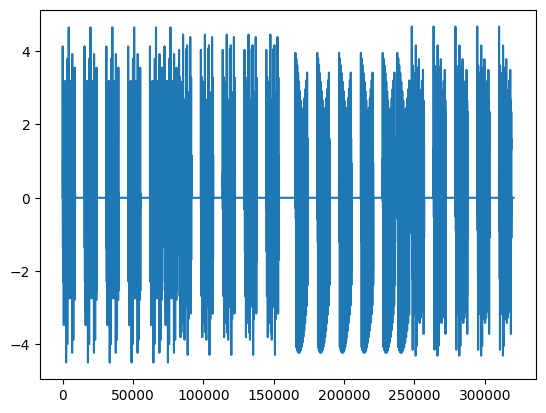

In [91]:
plt.plot(A)

audio = convert_to_audio(A)
ipd.Audio(audio, rate=SAMPLE_RATE)